## Introduction

This notebook generates book recommendations using two methods: collabortive filtering based on reader similarity and collaborative filtering based on predicted book ratings. The former uses KNN while the latter uses two forms of matrix factorization - first by singular value decomposition (SVD) and next by gradient descent using alternating least squares (ALS). 

Book and user ratings data come from the [Goodreads Book Graph Datasets](https://github.com/MengtingWan/goodreads]) produced by Mengting Wan, Rishabh Misra, Ndapa Nakashole, and Julian McAuley at UCSD. It has been imported, cleaned, and preprocessed in [00_prep_goodreads_data.ipynb](https://github.com/mraottth/projects/blob/main/Goodreads%20Book%20Recommender/00_prep_goodreads_data.ipynb). Genres, which are important for filtering recommendations but missing from the UCSD dataset, are inferred by topic modeling via latent dirichlet allocation (LDA) on book descriptions in [01_infer_genres.ipynb](https://github.com/mraottth/projects/blob/main/Goodreads%20Book%20Recommender/01_infer_genres.ipynb).

The target reader, for whom recommendations are being made in this notebook, is myself. To substitute your own Goodreads data and get personalized recommendations, go to the [Import/Export page](https://www.goodreads.com/review/import) on your Goodreads profile, download your books, and save as ```./data/goodreads_library_export.csv``` 

#### Contents

[Part 0: Preprocessing](#part-0-preprocessing)
- [0.1 - Load and Prepare Data](#01---load-and-prepare-data)
- [0.1 - Write Functions to Process Recommendations](#02---write-functions-to-process-recommendations)

[Part 1: Collaborative Filtering Based on Reader Similarity with KNN](#part-1---collaborative-filtering-based-on-reader-similarity-with-knn)
- [1.1 - Find Similar Readers](#11---find-similar-readers)
- [1.2 - Generate Recommendations](#12---generate-recommendations)


[Part 2: Collaborative Filtering Based on Predicted Ratings with Matrix Factorization](#part-2---collaborative-filtering-based-on-predicted-ratings-with-matrix-factorization)
- [2.1 - Factorize User-Rating Matrix with SVD](#21---factorize-user-rating-matrix-with-svd)
- [2.2 - Generate Recommendations by Predicting Ratings](#22---generate-recommendations-by-predicting-ratings)
- [2.3 - Matrix Factorization with Gradient Descent](#23-matrix-factorization-with-gradient-descent)

## Part 0: Preprocessing

In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import sparse
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import Normalizer
from IPython.display import display
from scipy.sparse.linalg import svds

### 0.1 - Load and Prepare Data

In [125]:
# Load df_books and genres
wd = os.getcwd()
df_books = pd.read_csv(wd + "/data/goodreads_books.csv")
df_inferred_genres = pd.read_csv(wd + "/data/inferred_genres.csv")
genre_descriptors = pd.read_csv(wd + "/data/inferred_genre_top_words.csv")

# Join genres to books
df_books = pd.merge(df_books, df_inferred_genres.drop(columns="title"), how="left", on="book_id")

# Filter out kids books
df_books = df_books[df_books.loc[:,"children":"comic"].sum(axis=1) < 2]

In [126]:
# Load sparse_reviews from file
df_reviews = sparse.load_npz(wd + "/data/user_reviews.npz")

# Load user (rows) and book (cols) indices
user_index = pd.read_csv(wd + "/data/user_index_for_sparse_matrix.csv").rename(columns={"0":"user_id"})
book_index = pd.read_csv(wd + "/data/book_index_for_sparse_matrix.csv").rename(columns={"0":"book_id"})

In [127]:
# Load my goodreads history
my_books = pd.read_csv(wd + "/data/goodreads_library_export.csv")

# Filter to books I've rated
my_books = my_books[["Book Id", "My Rating", "Title"]]\
    .rename(columns={"Book Id":"book_id", "My Rating":"rating", "Title":"title"}).query("rating > 0")
print(f"Target reader ratings: {my_books.shape[0]}")

# Reformat to fit sparse matrix
my_books_1 = pd.merge(
                my_books, df_books[["book_id", "title"]], 
                how="left", on="book_id", suffixes=["_mb","_dfb"]
            )
my_books_id_match = my_books_1[~my_books_1["title_dfb"].isna()]
print(f"Matching on book_id: {my_books_id_match.shape[0]}")

my_books_2 = pd.merge(
    my_books_1[my_books_1["title_dfb"].isna()], df_books[["book_id", "title"]], 
    how="left", left_on="title_mb", right_on="title", suffixes=["_mb","_dfb"]
    )
my_books_match_on_title = my_books_2[~my_books_2["title"].isna()]
print(f"Matching on title: {my_books_match_on_title.shape[0]}")

my_books_id_match = my_books_id_match[["book_id", "rating", "title_dfb"]]\
                        .rename(columns={"title_dfb":"title"})
my_books_match_on_title = my_books_match_on_title[["book_id_dfb", "rating", "title"]]\
                        .rename(columns={"book_id_dfb":"book_id"})

my_books_3 = pd.concat([my_books_id_match, my_books_match_on_title])
my_books_3 = my_books_3.drop_duplicates(subset="book_id")
print(f"Total matches: {my_books_3.shape[0]}, {(my_books_3.shape[0] / my_books.shape[0]):.2%} of total")

my_books_4 = pd.merge(book_index, my_books_3, how="left", on="book_id").fillna(0.)
my_books = np.array(my_books_4["rating"]).reshape(1,-1)

# Add to sparse matrix
df_reviews = sparse.vstack([df_reviews, my_books])
df_reviews = sparse.csr_matrix(df_reviews)

# Normalize reviews within readers for KNN
norm = Normalizer()
df_reviews_norm = norm.fit_transform(df_reviews) 

Target reader ratings: 168
Matching on book_id: 30
Matching on title: 64
Total matches: 94, 55.95% of total


In [128]:
# Set target reader to make recommendations for
target = df_reviews.shape[0] - 1

#### 0.2 - Write Functions to Process Recommendations

In [129]:
# Function to use KNN to find similar users
def find_neighbors(n_neighbors, target_user, ratings_df, ind_books, books):

    # Instantiate KNN
    n_neighbors = n_neighbors

    nn_model = NearestNeighbors(
        metric="cosine",
        algorithm="auto",
        n_neighbors=n_neighbors,
        n_jobs=-1
    )

    # Fit to sparse matrix
    nn_model.fit(ratings_df)

    # Feed in user and get neighbors and distances
    reader = ratings_df[target,:].toarray()
    dists, neighbors = nn_model.kneighbors(reader, return_distance=True)

    similar_users = pd.DataFrame(
        [pd.Series(neighbors.reshape(-1)), pd.Series(dists.reshape(-1))]).T.rename(
            columns={0:"user", 1:"distance"}
    )

    # Get all books read by similar users
    book_ind = []
    book_rat = []
    uid = []
    target_user_books = []
    target_user_book_rat = []
    for nt in similar_users.itertuples():
        user = ratings_df[int(nt.user),:].toarray()
        book_inds = np.where(user[0] > 0)[0]
        ratings = user[0][np.where(user[0] > 0)[0]]
        for i in range(len(book_inds)):        
            book_ind.append(book_inds[i])
            book_rat.append(ratings[i])
            uid.append(nt.user)    
            if nt.distance < 0.000000001:
                target_user_books.append(book_inds[i])
                target_user_book_rat.append(ratings[i])

    neighbor_user_ratings = pd.DataFrame([uid, book_ind, book_rat]).T.rename(
                                columns={0:"uid",1:"book_index",2:"user_rating"}
                            )

    # Join overall rating for each book
    neighbor_user_ratings = pd.merge(
                                ind_books.reset_index(), neighbor_user_ratings, 
                                how="inner", left_on="index", right_on="book_index"
                            )
    neighbor_user_ratings = pd.merge(neighbor_user_ratings, books, how="inner", on="book_id")

    # Filter out books target reader has already read
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["book_index"].isin(target_user_books)]
    neighbor_user_ratings.drop(["index"], axis=1, inplace=True)

    # Filter out later volumes in series using regex pattern
    regex1 = r"#([2-9]|[1-9]\d+)"
    regex2 = r"Vol. ([0-9]|[1-9]\d+)"
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex1)]
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex2)]
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains("#1-")]

    # View target user's ratings
    target_user_ratings = pd.DataFrame(
                            [target_user_books, target_user_book_rat]).T.rename(
                                columns={0:"book_index",1:"user_rating"}
                        )
    target_user_ratings = pd.merge(
                            ind_books.reset_index(), target_user_ratings,
                            how="inner", left_on="index", right_on="book_index"
                        )
    target_user_ratings = pd.merge(target_user_ratings, books, how="inner", on="book_id")    

    return neighbor_user_ratings, target_user_ratings

In [130]:
# Function to show top recs for each genre
def show_top_recs_by_genre(
        target, others, preds=None, how=["KNN", "MF"], whose_genres=["target", "neighbors"], 
        n_genres=5, min_score=3.9, min_ratings=400, n_recs=15, write_to_excel=False):

    if whose_genres == "target":
        genre_ranking = pd.DataFrame(target.loc[:, "Genre_1":].sum(axis=0).sort_values(ascending=False))
    else:
        genre_ranking = pd.DataFrame(others.loc[:, "Genre_1":].sum(axis=0).sort_values(ascending=False))    
    
    genres = []
    results = []
    # Loop through genres in descending relevance order and print top recs
    for genre in genre_ranking.index[0:n_genres]:        
        
        g = float(genre[6:])
        if how == "KNN":
            highest_rated_recs_genre = others.query("main_genre == @g")\
                .groupby(["title", "avg_rating", "ratings_count", "year", "url"])["book_id"]\
                .count().reset_index().sort_values(by=["avg_rating", "book_id"], ascending=False)
        
        elif how == "MF":
            highest_rated_recs_genre = preds.query("main_genre == @g")\
            .sort_values(by="predicted_rating", ascending=False)                

        highest_rated_recs_genre = highest_rated_recs_genre.query(
                                        "ratings_count > @min_ratings & avg_rating > @min_score"
                                    )

        # Print genre name and descriptor
        for nt in genre_descriptors.itertuples():
            genre_rep = genre.replace("_"," ")
            if nt.genre_string[0:len(f"{genre}:")] == f"{genre_rep}:":
                gs = (nt.genre_string)
        
        genres.append(gs)
        results.append(highest_rated_recs_genre[["title", "avg_rating", "ratings_count", "url"]].head(50))

        print(gs)
        display(highest_rated_recs_genre[["title", "avg_rating", "ratings_count", "url"]].head(n_recs))
        print("_____\n")
    
    # Write to excel if keyword set
    path = (wd + "/data/book_recs.xlsx")
    if write_to_excel == True:
        if os.path.isfile(path):
            with pd.ExcelWriter(path, engine="openpyxl", mode="a", if_sheet_exists='replace') as writer:
                
                pd.DataFrame(genres).rename(columns={0:"Genres"})\
                    .to_excel(writer, sheet_name="Genre Meanings", index=False)
                
                for i in range(len(results)):
                    results[i].to_excel(writer, sheet_name=f"{genres[i].split(':')[0]} Recs", index=False)
        else:
            with pd.ExcelWriter(path) as writer:
                
                pd.DataFrame(genres).rename(columns={0:"Genres"})\
                    .to_excel(writer, sheet_name="Genre Meanings", index=False)
                
                for i in range(len(results)):
                    results[i].to_excel(writer, sheet_name=f"{genres[i].split(':')[0]} Recs", index=False)
        writer.close

In [131]:
# Functions to show top rated and most popular among similar readers
def neighbors_most_popular(others, n=10, min_ratings=1000, min_score=3.8, write_to_excel=False):
    
    popular_recs = others.query("ratings_count > @min_ratings & avg_rating > @min_score")\
        .groupby(["title", "avg_rating", "ratings_count", "year","url"])["book_id"]\
        .count().reset_index().sort_values(by=["book_id", "avg_rating"], ascending=False)\
        .nlargest(n, "book_id").rename(columns={"book_id":"percent_similar_users_read"})

    popular_recs["percent_similar_users_read"] = (popular_recs["percent_similar_users_read"] / 
                                                    others["uid"].nunique()).map('{:.1%}'.format)
    
    # Write to excel if keyword set
    path = (wd + "/data/book_recs.xlsx")
    if write_to_excel == True:
        if os.path.isfile(path):
            with pd.ExcelWriter(path, engine="openpyxl", mode="a", if_sheet_exists='replace') as writer:
                popular_recs.to_excel(writer, sheet_name="Popular Among Similar Readers", index=False)
        else:
            with pd.ExcelWriter(path) as writer:
                popular_recs.to_excel(writer, sheet_name="Popular Among Similar Readers", index=False)
                
        writer.close

    return popular_recs[["title","avg_rating","ratings_count","year","percent_similar_users_read","url"]]


def neighbors_top_rated(others, n=10, min_ratings=1000, min_score=3.8, write_to_excel=False):

    highest_rated_recs = others.query("ratings_count > @min_ratings & avg_rating > @min_score")\
        .groupby(["title", "avg_rating", "ratings_count", "year","url"])["book_id"]\
        .count().reset_index().sort_values(by=["avg_rating", "book_id"], ascending=False)\
        .nlargest(n, "avg_rating").drop(columns="book_id")
    
    # Write to excel if keyword set
    path = (wd + "/data/book_recs.xlsx")
    if write_to_excel == True:
        if os.path.isfile(path):
            with pd.ExcelWriter(path, engine="openpyxl", mode="a", if_sheet_exists='replace') as writer:
                highest_rated_recs.to_excel(writer, sheet_name="Top Rated Among Similar Readers", index=False)
        else:
            with pd.ExcelWriter(path) as writer:
                highest_rated_recs.to_excel(writer, sheet_name="Top Rated Among Similar Readers", index=False)
                
        writer.close

    return highest_rated_recs

In [132]:
# Function to plot neighbors' and target's top genres
def plot_top_genres(others, target):
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,10))
    neighbor_genre_ranking = pd.DataFrame(others.loc[:, "Genre_1":].sum(axis=0).sort_values(ascending=False))
    target_genre_ranking = pd.DataFrame(target.loc[:, "Genre_1":].sum(axis=0).sort_values(ascending=False))
    
    sns.barplot(
        data=neighbor_genre_ranking, y=neighbor_genre_ranking.index, x=0, ax=ax[0], color="tab:blue"
    )
    ax[0].set_xlabel("Genre preference")
    ax[0].set_title("Neighbors' Top Genres")

    # Plot target reader's top genres    
    sns.barplot(
        data=target_genre_ranking, y=target_genre_ranking.index, x=0, ax=ax[1], color="tab:orange"
    )
    ax[1].set_xlabel("Genre preference")
    ax[1].set_title("Target User's Top Genres")
    
    plt.show()

## Part 1 - Collaborative Filtering Based on Reader Similarity with KNN

In this section, we use K-Nearest Neighbors (KNN) to find the readers most similar to our target reader. Each reader's ratings on all books in the dataset are encoded as vectors where unread books are given a value of 0. We use cosine similarity to find the users whose ratings are most similar to the target and then filter among their books to find the most popular and highest rated.

### 1.1 - Find Similar Readers

In [133]:
# Perform KNN on user rating matrix
neighbor_user_ratings, target_user_ratings = find_neighbors(75, target, df_reviews_norm, book_index, df_books)

/var/folders/hf/1k3w_wb93bd1yp7b5_jh65mw0000gn/T/ipykernel_67953/1715287364.py:62: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex1)]
/var/folders/hf/1k3w_wb93bd1yp7b5_jh65mw0000gn/T/ipykernel_67953/1715287364.py:63: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex2)]


<a id='Part1.2'></a>
### 1.2 - Generate Recommendations

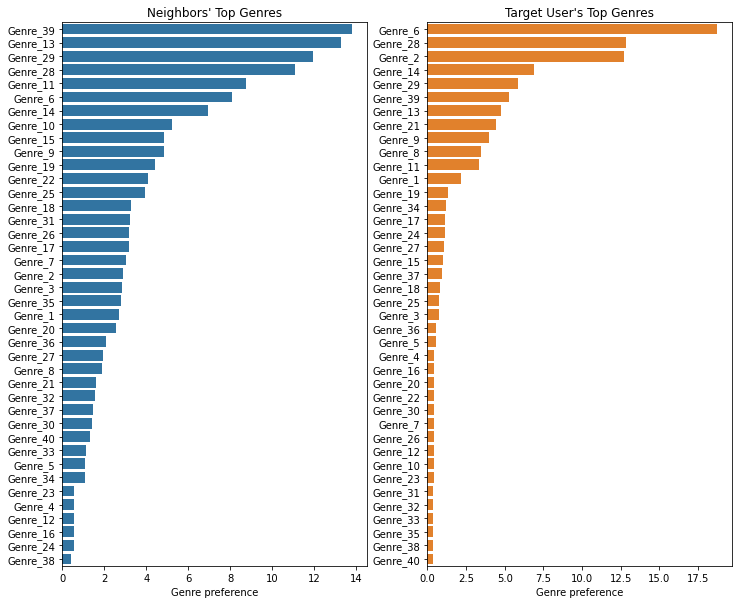

In [134]:
# Show top genres
plot_top_genres(neighbor_user_ratings, target_user_ratings)

In [135]:
# View most popular books among neighbors
neighbors_most_popular(neighbor_user_ratings, 15, min_ratings=2000, write_to_excel=False)

,title,avg_rating,ratings_count,year,percent_similar_users_read,url
32,The Hundred Thousand Kingdoms (Inheritance Tri...,3.81,30194.0,2010,3.6%,https://www.goodreads.com/book/show/6437061-th...
14,In Order to Live: A North Korean Girl's Journe...,4.48,8076.0,2015,1.8%,https://www.goodreads.com/book/show/24611623-i...
3,Assata: An Autobiography,4.47,11057.0,1999,1.8%,https://www.goodreads.com/book/show/100322.Assata
22,Shoe Dog: A Memoir by the Creator of NIKE,4.44,27468.0,2016,1.8%,https://www.goodreads.com/book/show/27220736-s...
28,The Cartel,4.29,9961.0,2015,1.8%,https://www.goodreads.com/book/show/23602561-t...
33,The Invention of Nature: Alexander von Humbold...,4.29,4817.0,2015,1.8%,https://www.goodreads.com/book/show/23995249-t...
31,The Creature from Jekyll Island: A Second Look...,4.28,2517.0,2002,1.8%,https://www.goodreads.com/book/show/66499.The_...
1,"Age of Myth (The Legends of the First Empire, #1)",4.27,9328.0,2016,1.8%,https://www.goodreads.com/book/show/26863057-a...
42,When Christ and His Saints Slept (Henry II an...,4.27,10892.0,1996,1.8%,https://www.goodreads.com/book/show/43841.When...
37,The Silk Roads: A New History of the World,4.25,3022.0,2015,1.8%,https://www.goodreads.com/book/show/25812847-t...


In [136]:
# View highest rated books among similar readers
neighbors_top_rated(neighbor_user_ratings, 15, min_ratings=2000, write_to_excel=False)

,title,avg_rating,ratings_count,year,url
14,In Order to Live: A North Korean Girl's Journe...,4.48,8076.0,2015,https://www.goodreads.com/book/show/24611623-i...
3,Assata: An Autobiography,4.47,11057.0,1999,https://www.goodreads.com/book/show/100322.Assata
22,Shoe Dog: A Memoir by the Creator of NIKE,4.44,27468.0,2016,https://www.goodreads.com/book/show/27220736-s...
28,The Cartel,4.29,9961.0,2015,https://www.goodreads.com/book/show/23602561-t...
33,The Invention of Nature: Alexander von Humbold...,4.29,4817.0,2015,https://www.goodreads.com/book/show/23995249-t...
31,The Creature from Jekyll Island: A Second Look...,4.28,2517.0,2002,https://www.goodreads.com/book/show/66499.The_...
1,"Age of Myth (The Legends of the First Empire, #1)",4.27,9328.0,2016,https://www.goodreads.com/book/show/26863057-a...
42,When Christ and His Saints Slept (Henry II an...,4.27,10892.0,1996,https://www.goodreads.com/book/show/43841.When...
37,The Silk Roads: A New History of the World,4.25,3022.0,2015,https://www.goodreads.com/book/show/25812847-t...
44,"Wool Omnibus (Silo, #1)",4.24,83601.0,2012,https://www.goodreads.com/book/show/13453029-w...


In [137]:
# View highest rated books by each of the top genres
show_top_recs_by_genre(
    target=target_user_ratings, 
    others=neighbor_user_ratings, 
    how="KNN", 
    whose_genres="target", 
    n_genres=5, 
    min_score=3.9, 
    min_ratings=400, 
    n_recs=15,
    write_to_excel=False
)

Genre 6: ['history', 'war', 'political', 'account', 'world', 'government', 'country', 'nation', 'military', 'year']


,title,avg_rating,ratings_count,url
7,War's Unwomanly Face,4.52,1182.0,https://www.goodreads.com/book/show/4025275-wa...
0,Assata: An Autobiography,4.47,11057.0,https://www.goodreads.com/book/show/100322.Assata
6,The Silk Roads: A New History of the World,4.25,3022.0,https://www.goodreads.com/book/show/25812847-t...
1,Capital in the Twenty-First Century,4.02,13494.0,https://www.goodreads.com/book/show/18736925-c...
5,The Rational Optimist: How Prosperity Evolves,3.98,4894.0,https://www.goodreads.com/book/show/7776209-th...
4,Rolling in the Deep (Rolling in the Deep #0.5),3.94,1569.0,https://www.goodreads.com/book/show/23634011-r...


_____

Genre 28: ['science', 'human', 'theory', 'scientific', 'world', 'history', 'scientist', 'philosophy', 'question', 'modern']


,title,avg_rating,ratings_count,url
7,New Seeds of Contemplation,4.31,913.0,https://www.goodreads.com/book/show/1145854.Ne...
11,The Invention of Nature: Alexander von Humbold...,4.29,4817.0,https://www.goodreads.com/book/show/23995249-t...
6,Mountains Beyond Mountains: The Quest of Dr. P...,4.21,53936.0,https://www.goodreads.com/book/show/10235.Moun...
1,Dirt: The Erosion of Civilizations,3.94,736.0,https://www.goodreads.com/book/show/587916.Dirt
8,Octavia's Brood: Science Fiction Stories from ...,3.94,1088.0,https://www.goodreads.com/book/show/23129839-o...
9,"The Clockwork Universe: Isaac Newton, the Roya...",3.91,3763.0,https://www.goodreads.com/book/show/9449985-th...


_____

Genre 2: ['alien', 'planet', 'world', 'human', 'race', 'space', 'humanity', 'war', 'galaxy', 'year']


,title,avg_rating,ratings_count,url
2,"Wool Omnibus (Silo, #1)",4.24,83601.0,https://www.goodreads.com/book/show/13453029-w...
1,Pandemic (The Extinction Files #1),4.11,7066.0,https://www.goodreads.com/book/show/34811896-p...


_____

Genre 14: ['history', 'biography', 'music', 'world', 'culture', 'century', 'year', 'time', 'great', 'film']


,title,avg_rating,ratings_count,url
4,Shoe Dog: A Memoir by the Creator of NIKE,4.44,27468.0,https://www.goodreads.com/book/show/27220736-s...
0,Asking for It: The Alarming Rise of Rape Cultu...,4.39,1721.0,https://www.goodreads.com/book/show/17836520-a...
1,Feminism is for Everybody: Passionate Politics,4.18,7740.0,https://www.goodreads.com/book/show/168484.Fem...
7,The Purity Myth: How America's Obsession with ...,4.06,5741.0,https://www.goodreads.com/book/show/4914761-th...
3,Nervous Conditions,3.92,6949.0,https://www.goodreads.com/book/show/158674.Ner...
5,The Affirmation,3.92,893.0,https://www.goodreads.com/book/show/106925.The...


_____

Genre 29: ['family', 'young', 'world', 'memoir', 'year', 'moving', 'child', 'time', 'voice', 'funny']


,title,avg_rating,ratings_count,url
5,My Journey : Transforming Dreams into Actions,4.35,1743.0,https://www.goodreads.com/book/show/18371021-m...
10,The Woman on the Orient Express,4.15,2305.0,https://www.goodreads.com/book/show/29806077-t...
1,Beyond the Sky and the Earth: A Journey into B...,4.13,2641.0,https://www.goodreads.com/book/show/145249.Bey...
12,Those Who Save Us,4.12,4984.0,https://www.goodreads.com/book/show/10316205-t...
7,Stag's Leap: Poems,4.10,1975.0,https://www.goodreads.com/book/show/13330670-s...
11,This is the Story of a Happy Marriage,4.03,13538.0,https://www.goodreads.com/book/show/17349222-t...
13,Who Asked You?,3.93,3428.0,https://www.goodreads.com/book/show/17572866-w...
6,No One Cares About Crazy People: The Chaos and...,3.92,834.0,https://www.goodreads.com/book/show/30363776-n...


_____



## Part 2 - Collaborative Filtering Based on Predicted Ratings with Matrix Factorization

In sections [2.1](#21---factorize-user-rating-matrix-with-svd) and [2.2](#22---generate-recommendations-by-predicting-ratings) we use singular value decomposition (SVD) to factorize the user-rating matrix generated from the 1500 most similar readers to the target reader, as determined by KNN. SVD decomposes our $m * n$ user-rating matrix $R$ into 3 smaller matrices: $$R = U \Sigma \mathbf{V}^\top$$ where $U$, the left singular vectors, represents an $m * k$ embedding space of user features and $\mathbf{V}^\top$, the right singular vectors, represents a $k * n$ embedding of book features. Estimated ratings come from multiplying the decomposed matrices together to approximate $R$. 

The advantage of SVD is its simplicity and computational efficiency. The disadvantage is that it requires unseen ratings to be encoded as 0 and therefore all predicted ratings on unread books are near zero rather than more realistic values. 

-----

In section [2.3](#23-matrix-factorization-with-gradient-descent) we use gradient descent to train user and book embedding matrices $P$ and $Q$. We minimize the loss function: $$L = (r_{ij} - \sum_{k=1}^{K} p_{ik}q_{kj})^2 + \frac{\beta}{2}\sum_{k=1}^{K}(||P||^2 + ||Q||^2)$$ for all $r_{ij} > 0$ using alternating least squares. After training, we reconstruct $R$ matrix by multiplyting $P * Q$. See [here](http://www.quuxlabs.com/blog/2010/09/matrix-factorization-a-simple-tutorial-and-implementation-in-python/) for a helpful description of th math.

The advantage of gradient descent is that we can train the model on nonzero ratings (i.e. only for books users have actually rated) and apply it to unread books, which yields realistic rating predictions. The downside is that it is computationally very expensive. Larger user-raing $R$ matrices have exponentially more values than smaller ones, so there is a limit to how many nearest neighbors we can use to generate the full set of book ratings to consider. 

#### 2.1 - Factorize User-Rating Matrix with SVD

In [138]:
# Find larger number of similar users than before to get broad pool of potentially relevant books
svd_neighborhood_ratings, target_user_ratings = find_neighbors(
                                                    1500, target, df_reviews_norm, book_index, df_books)

/var/folders/hf/1k3w_wb93bd1yp7b5_jh65mw0000gn/T/ipykernel_67953/1715287364.py:62: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex1)]
/var/folders/hf/1k3w_wb93bd1yp7b5_jh65mw0000gn/T/ipykernel_67953/1715287364.py:63: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex2)]


In [139]:
# Get unique users and books to slice df_reviews
svd_neighbor_index = svd_neighborhood_ratings["uid"].unique()
svd_neighbor_index = np.append(svd_neighbor_index, target)
svd_neighbor_book_index = svd_neighborhood_ratings["book_index"].unique()
svd_neighbor_book_index = np.append(svd_neighbor_book_index, target_user_ratings["book_index"].unique())

print(f"\nNeighborhood contains {svd_neighborhood_ratings.shape[0]} books")

# Slice df_reviews to make User Ratings Matrix
R = df_reviews[:, svd_neighbor_book_index]
R = R[svd_neighbor_index, :]


Neighborhood contains 10321 books


In [140]:
# Decompose user ratings matrix R with SVD
U, sigma, Vt = svds(R, k=5)
sigma = np.diag(sigma)

# Convert to sparse matrix
U = sparse.csr_matrix(U)
sigma = sparse.csr_matrix(sigma)
Vt = sparse.csr_matrix(Vt)

#### 2.2 - Generate Recommendations by Predicting Ratings

In [141]:
# Get predictions
all_user_predicted_ratings = U.dot(sigma) @ Vt
df_preds = pd.DataFrame(
                all_user_predicted_ratings.toarray(), columns=svd_neighbor_book_index, index=svd_neighbor_index
                ).reset_index()

In [142]:
# Get top recs from predictions
def get_recs(preds, target_reader, book_ind, books, write_to_excel=False):
    
    target_pred_books = preds[preds["index"] == target_reader].columns[1:]
    target_pred_ratings = preds[preds["index"] == target_reader].values[0][1:]

    # Put into df with relevant info from df_books
    top_preds = pd.DataFrame({"book_index":target_pred_books, "predicted_rating":target_pred_ratings})\
                    .sort_values(by="predicted_rating", ascending=False)\
                    .merge(book_ind.reset_index(), left_on="book_index", right_on="index")\
                    .merge(
                        books[["book_id", "title", "avg_rating", "ratings_count", "year", "main_genre","url"]],
                        on="book_id"
                    )\
                    .drop(columns=["index", "book_id"])

    # Filter out already read books
    top_preds = top_preds[~top_preds["book_index"].isin(target_user_ratings["book_index"].unique())]
    top_preds.drop(["book_index"], axis=1, inplace=True)

    if write_to_excel == True:
        # Write to excel
        path = wd + "/data/book_recs.xlsx"
        if os.path.isfile(path):
            with pd.ExcelWriter(path, engine="openpyxl", mode="a", if_sheet_exists='replace') as writer:
                top_preds.query("avg_rating > 3.9").drop(columns=["predicted_rating", "main_genre"])\
                    .head(50).to_excel(writer, sheet_name="Top by Predicted Score", index=False)
        else:
            with pd.ExcelWriter(path) as writer:
                top_preds.query("avg_rating > 3.9").drop(columns=["predicted_rating", "main_genre"])\
                    .head(50).to_excel(writer, sheet_name="Top by Predicted Score", index=False)
        writer.close

    return top_preds

In [173]:
# View books with highest target user predicted score
top_preds = get_recs(df_preds, target, book_index, df_books, write_to_excel=False)
top_preds[["title","avg_rating","predicted_rating","ratings_count","year","url"]]\
                .query("avg_rating > 4.1 & ratings_count > 2000").head(20)

,title,avg_rating,predicted_rating,ratings_count,year,url
5,"I, Robot (Robot #0.1)",4.17,0.502334,201196.0,2004,https://www.goodreads.com/book/show/41804.I_Robot
8,"The Pillars of the Earth (Kingsbridge, #1)",4.29,0.356798,471990.0,2002,https://www.goodreads.com/book/show/5043.The_P...
9,"Wool Omnibus (Silo, #1)",4.24,0.352464,83601.0,2012,https://www.goodreads.com/book/show/13453029-w...
12,Evicted: Poverty and Profit in the American City,4.47,0.288474,18205.0,2016,https://www.goodreads.com/book/show/25852784-e...
15,The Caves of Steel (Robot #1),4.14,0.246245,52229.0,1997,https://www.goodreads.com/book/show/41811.The_...
16,The New Jim Crow: Mass Incarceration in the Ag...,4.49,0.243607,24694.0,2010,https://www.goodreads.com/book/show/6792458-th...
25,"Surely You're Joking, Mr. Feynman!: Adventures...",4.29,0.198764,95353.0,1997,https://www.goodreads.com/book/show/5544.Surel...
27,Saga: Book One,4.70,0.193439,4201.0,2014,https://www.goodreads.com/book/show/22078240-saga
30,Shoe Dog: A Memoir by the Creator of NIKE,4.44,0.189504,27468.0,2016,https://www.goodreads.com/book/show/27220736-s...
33,Letter from the Birmingham Jail,4.64,0.187218,2776.0,1994,https://www.goodreads.com/book/show/203899.Let...


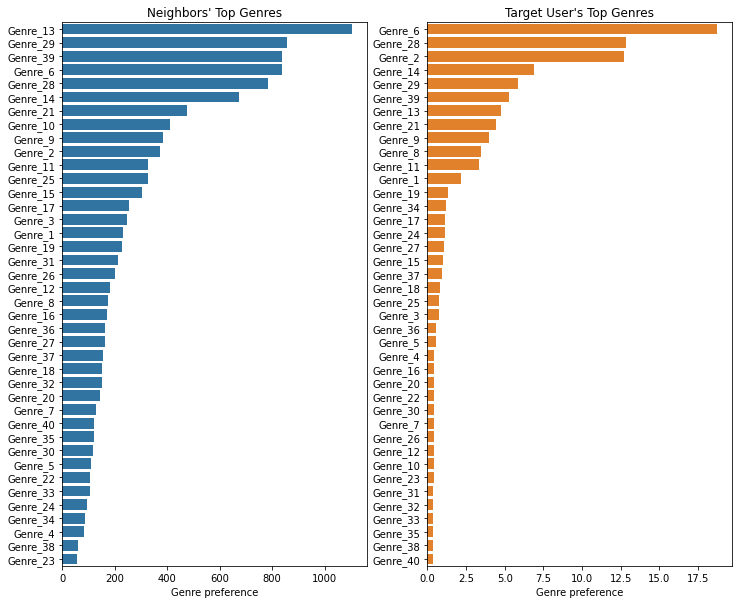

In [144]:
# Show top genres
plot_top_genres(svd_neighborhood_ratings, target_user_ratings)

In [145]:
# View most popular books among neighbors
popular_recs = neighbors_most_popular(svd_neighborhood_ratings, 50, min_ratings=2000, write_to_excel=False)
popular_recs.head(15)

,title,avg_rating,ratings_count,year,percent_similar_users_read,url
1026,"Rich Dad, Poor Dad",3.96,164543.0,2007,1.7%,https://www.goodreads.com/book/show/69571.Rich...
110,All the Ugly and Wonderful Things,4.10,35002.0,2016,1.6%,https://www.goodreads.com/book/show/26114135-a...
170,Bad Feminist,3.91,43988.0,2014,1.6%,https://www.goodreads.com/book/show/18813642-b...
1620,"The Pillars of the Earth (Kingsbridge, #1)",4.29,471990.0,2002,1.5%,https://www.goodreads.com/book/show/5043.The_P...
1451,The Gunslinger,3.98,346978.0,1982,1.5%,https://www.goodreads.com/book/show/43615.The_...
1204,Talking as Fast as I Can: From Gilmore Girls t...,4.03,35052.0,2016,1.5%,https://www.goodreads.com/book/show/30253864-t...
1093,Shoe Dog: A Memoir by the Creator of NIKE,4.44,27468.0,2016,1.2%,https://www.goodreads.com/book/show/27220736-s...
1440,The Golem and the Jinni (The Golem and the Jin...,4.10,61387.0,2013,1.2%,https://www.goodreads.com/book/show/15819028-t...
133,"Angels & Demons (Robert Langdon, #1)",3.86,2046499.0,2006,1.2%,https://www.goodreads.com/book/show/960.Angels...
455,Evicted: Poverty and Profit in the American City,4.47,18205.0,2016,1.1%,https://www.goodreads.com/book/show/25852784-e...


In [146]:
# Highest rated books among similar readers
top_rated = neighbors_top_rated(svd_neighborhood_ratings, min_ratings=2000, write_to_excel=False)
top_rated.head(15)

,title,avg_rating,ratings_count,year,url
1059,Saga: Book One,4.70,4201.0,2014,https://www.goodreads.com/book/show/22078240-saga
27,A Game of Thrones: The Book of Ice and Fire RP...,4.67,7486.0,2004,https://www.goodreads.com/book/show/4700482-a-...
1773,"The Way of Kings, Part 1 (The Stormlight Archi...",4.67,10191.0,2011,https://www.goodreads.com/book/show/9329354-th...
1474,The Holy Bible: English Standard Version,4.66,18613.0,2007,https://www.goodreads.com/book/show/5883777-th...
758,Letter from the Birmingham Jail,4.64,2776.0,1994,https://www.goodreads.com/book/show/203899.Let...
1765,"The Walking Dead, Compendium 3",4.62,4378.0,2015,https://www.goodreads.com/book/show/25536846-t...
602,Holy Bible: New International Version,4.61,42213.0,1985,https://www.goodreads.com/book/show/280111.Hol...
80,"A Voice in the Wind (Mark of the Lion, #1)",4.59,57014.0,1993,https://www.goodreads.com/book/show/95617.A_Vo...
347,Dan and Phil Go Outside,4.59,2229.0,2016,https://www.goodreads.com/book/show/30613790-d...
1303,"The Cartel (The Cartel, #1)",4.58,5703.0,2009,https://www.goodreads.com/book/show/5953477-th...


In [147]:
# Highest rated books by each of the top genres
show_top_recs_by_genre(
    target_user_ratings, 
    svd_neighborhood_ratings, 
    preds=top_preds, 
    how="MF", 
    whose_genres="target", 
    n_genres=5, 
    min_score=4.15, 
    min_ratings=2000, 
    n_recs=20,
    write_to_excel=False
)

Genre 6: ['history', 'war', 'political', 'account', 'world', 'government', 'country', 'nation', 'military', 'year']


,title,avg_rating,ratings_count,url
16,The New Jim Crow: Mass Incarceration in the Ag...,4.49,24694.0,https://www.goodreads.com/book/show/6792458-th...
76,The Silk Roads: A New History of the World,4.25,3022.0,https://www.goodreads.com/book/show/25812847-t...
94,A Fighting Chance,4.17,8740.0,https://www.goodreads.com/book/show/18779662-a...
126,Bloodlands: Europe Between Hitler and Stalin,4.33,5785.0,https://www.goodreads.com/book/show/6572270-bl...
106,Lenin's Tomb: The Last Days of the Soviet Empire,4.18,2781.0,https://www.goodreads.com/book/show/113206.Len...
161,Citizens of London: The Americans who Stood wi...,4.19,4517.0,https://www.goodreads.com/book/show/6947702-ci...
203,The Coldest Winter: America and the Korean War,4.19,5070.0,https://www.goodreads.com/book/show/448135.The...
251,"Ghost Wars: The Secret History of the CIA, Afg...",4.28,9239.0,https://www.goodreads.com/book/show/71984.Ghos...
281,The Girl with Seven Names: A North Korean Defe...,4.45,8293.0,https://www.goodreads.com/book/show/25362017-t...
386,We Wish to Inform You That Tomorrow We Will Be...,4.29,19564.0,https://www.goodreads.com/book/show/11472.We_W...


_____

Genre 28: ['science', 'human', 'theory', 'scientific', 'world', 'history', 'scientist', 'philosophy', 'question', 'modern']


,title,avg_rating,ratings_count,url
5,"I, Robot (Robot #0.1)",4.17,201196.0,https://www.goodreads.com/book/show/41804.I_Robot
25,"Surely You're Joking, Mr. Feynman!: Adventures...",4.29,95353.0,https://www.goodreads.com/book/show/5544.Surel...
57,Harry Potter and the Methods of Rationality,4.38,8691.0,https://www.goodreads.com/book/show/10016013-h...
160,Algorithms to Live By: The Computer Science of...,4.16,4639.0,https://www.goodreads.com/book/show/25666050-a...
168,Dragons of Eden: Speculations on the Evolution...,4.16,13576.0,https://www.goodreads.com/book/show/32276.Drag...
278,Why Evolution Is True,4.16,15226.0,https://www.goodreads.com/book/show/4005310-wh...
335,The Gene: An Intimate History,4.36,9874.0,https://www.goodreads.com/book/show/27276428-t...
387,Guns,4.17,3687.0,https://www.goodreads.com/book/show/17284577-guns
396,"Delusions of Gender: How Our Minds, Society, a...",4.16,4207.0,https://www.goodreads.com/book/show/8031168-de...
522,The Invention of Nature: Alexander von Humbold...,4.29,4817.0,https://www.goodreads.com/book/show/23995249-t...


_____

Genre 2: ['alien', 'planet', 'world', 'human', 'race', 'space', 'humanity', 'war', 'galaxy', 'year']


,title,avg_rating,ratings_count,url
9,"Wool Omnibus (Silo, #1)",4.24,83601.0,https://www.goodreads.com/book/show/13453029-w...
51,The Ultimate Hitchhiker's Guide to the Galaxy,4.38,225626.0,https://www.goodreads.com/book/show/13.The_Ult...
199,Pandora's Star,4.24,28964.0,https://www.goodreads.com/book/show/45252.Pand...
273,Lost Stars,4.25,9512.0,https://www.goodreads.com/book/show/25067046-l...
292,The Dreaming Void,4.18,16512.0,https://www.goodreads.com/book/show/866136.The...
433,"I, Robot (Robot, #0.1)",4.17,2235.0,https://www.goodreads.com/book/show/76684.I_Robot
442,A Good Man is Hard to Find and Other Stories,4.24,26384.0,https://www.goodreads.com/book/show/48464.A_Go...
532,Halo: The Fall of Reach,4.26,14823.0,https://www.goodreads.com/book/show/60229.Halo
583,Judas Unchained,4.30,21306.0,https://www.goodreads.com/book/show/45244.Juda...
692,"Live Free or Die (Troy Rising, #1)",4.16,6544.0,https://www.goodreads.com/book/show/6713634-li...


_____

Genre 14: ['history', 'biography', 'music', 'world', 'culture', 'century', 'year', 'time', 'great', 'film']


,title,avg_rating,ratings_count,url
30,Shoe Dog: A Memoir by the Creator of NIKE,4.44,27468.0,https://www.goodreads.com/book/show/27220736-s...
252,Malcolm X: A Life of Reinvention,4.20,11929.0,https://www.goodreads.com/book/show/7940589-ma...
271,The True Believer: Thoughts on the Nature of M...,4.23,3244.0,https://www.goodreads.com/book/show/15916.The_...
481,Principia Discordia ● Or ● How I Found Goddess...,4.27,4017.0,https://www.goodreads.com/book/show/89937.Prin...
628,Sounds Like Me: My Life (So Far) in Song,4.26,3867.0,https://www.goodreads.com/book/show/25434361-s...
797,"Notes from Underground, White Nights, The Drea...",4.17,66680.0,https://www.goodreads.com/book/show/17876.Note...
987,"The Autobiography of Martin Luther King, Jr.",4.32,11478.0,https://www.goodreads.com/book/show/42547.The_...
1417,Arguably: Selected Essays,4.19,6061.0,https://www.goodreads.com/book/show/10383597-a...
1429,The Truth: An Uncomfortable Book About Relatio...,4.20,2503.0,https://www.goodreads.com/book/show/26887738-t...
1852,The Road to Mecca,4.43,2322.0,https://www.goodreads.com/book/show/362413.The...


_____

Genre 29: ['family', 'young', 'world', 'memoir', 'year', 'moving', 'child', 'time', 'voice', 'funny']


,title,avg_rating,ratings_count,url
12,Evicted: Poverty and Profit in the American City,4.47,18205.0,https://www.goodreads.com/book/show/25852784-e...
279,Open,4.18,48230.0,https://www.goodreads.com/book/show/6480781-open
790,A Primate's Memoir: A Neuroscientist's Unconve...,4.33,4123.0,https://www.goodreads.com/book/show/32289.A_Pr...
1064,The Seven Good Years,4.16,2373.0,https://www.goodreads.com/book/show/23399025-t...
1100,"Seeking Allah, Finding Jesus: A Devout Muslim ...",4.54,6752.0,https://www.goodreads.com/book/show/18289396-s...
1178,Rising Strong,4.19,23667.0,https://www.goodreads.com/book/show/23317538-r...
1180,Desert Solitaire,4.22,28380.0,https://www.goodreads.com/book/show/214614.Des...
1403,"Redefining Realness: My Path to Womanhood, Ide...",4.30,4581.0,https://www.goodreads.com/book/show/18144031-r...
1416,You Don't Have to Say You Love Me,4.36,4478.0,https://www.goodreads.com/book/show/31420708-y...
1422,The Heart of a Woman,4.19,16156.0,https://www.goodreads.com/book/show/5160.The_H...


_____



### 2.3 Matrix Factorization with Gradient Descent

In [148]:
# Find larger number of similar users than before to get broad pool of potentially relevant books
gd_neighborhoodhood_ratings, target_user_ratings = find_neighbors(
                                                        1000, target, df_reviews_norm, book_index, df_books)

# Get unique users and books to slice df_reviews
gd_neighborhood_index = gd_neighborhoodhood_ratings["uid"].unique()
gd_neighborhood_index = np.append(gd_neighborhood_index, target)
gd_neighborhood_book_index = gd_neighborhoodhood_ratings["book_index"].unique()
gd_neighborhood_book_index = np.append(gd_neighborhood_book_index, target_user_ratings["book_index"].unique())
print(f"\nNeighborhood contains {gd_neighborhood_book_index.shape[0]} books")

# Slice df_reviews to make User Ratings Matrix
R = df_reviews[:, gd_neighborhood_book_index]
R = R[gd_neighborhood_index, :]
R = R.toarray()

/var/folders/hf/1k3w_wb93bd1yp7b5_jh65mw0000gn/T/ipykernel_67953/1715287364.py:62: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex1)]
/var/folders/hf/1k3w_wb93bd1yp7b5_jh65mw0000gn/T/ipykernel_67953/1715287364.py:63: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex2)]



Neighborhood contains 4004 books


In [149]:
# Function to train embedding matrices using alternating least squares (ALS) and make predictions 
def matrix_factorization(R, k_components=5, steps=4000, lr=0.0002, beta=0.03, decay=True, verbose=0):
    """
    Uses gradient descent to train matrix factorization algorithm

    Args:
        R: Utility matrix of user item ratings         
        k: Number of latent features
        steps: Number of epochs to run training
        lr: Learning rate
        beta: Regularization strength
        verbose: Prints updates if 1

    Returns:
        Predictions, User Embeddings, Item Embdeddings
    """

    # Initialize random values for user (P) and book (Q) embedding matrices    
    P = np.random.rand(R.shape[0],k_components)
    Q = np.random.rand(R.shape[1],k_components).T

    # Get nonzero ratings to perform operations on
    r_0 = np.where(R > 0) # Find indices where rating > 0
    i = r_0[0] # Get row indices where rating > 0
    j = r_0[1] # Get column indices where rating > 0 
    nonzero_ratings = R[i,j]

    # For each step calc residual and take step down gradient
    for step in range(steps): 
        resid = nonzero_ratings - (P @ Q)[i,j] # residual is value - r_hat       
        for k in range(k_components): # for each component (latent feature)                
            P[i,k] = P[i,k] + lr * (2 * resid * Q[k,j] - beta * P[i,k]) # Update P by step in gradient                             
            Q[k,j] = Q[k,j] + lr * (2 * resid * P[i,k] - beta * Q[k,j]) # Update Q by step in gradient            

        # Calculate error every n steps                  
        if ((step + 1) % 1000 == 0) | (step == 0): 
            error = 0 # Initialize counter for error  
            error = error + np.sum(pow(resid, 2)) # Add to error
            for k in range(k_components): # for each component (latent feature)                             
                error = error + (beta/2) * np.sum(pow(P[i,k],2) + pow(Q[k,j],2)) # Add regularized term            

            # View progress
            if verbose == 1:
                print(f"Step: {step + 1}, error: {error:.2f}, lr: {lr:.5f}") 
            
            # Set learning rate to decay until 0.00002
            if decay == True:
                if lr > 0.00002:                                
                    lr = lr / 2
    
    # Get predictions
    preds = np.dot(P, Q)

    return preds, P, Q.T

In [162]:
# Train model and get predictions
preds, user_embed, item_embed = matrix_factorization(
                                    R, 
                                    k_components=50, 
                                    lr=0.01, 
                                    beta=0.07,
                                    decay=True, 
                                    steps=6000, 
                                    verbose=1
                                )
df_preds_GD = pd.DataFrame(preds, columns=gd_neighborhood_book_index, index=gd_neighborhood_index)\
                .reset_index()

Step: 1, error: 454016.67, lr: 0.01000
Step: 1000, error: 4520.52, lr: 0.00500
Step: 2000, error: 3965.82, lr: 0.00250
Step: 3000, error: 3889.66, lr: 0.00125
Step: 4000, error: 3885.29, lr: 0.00063
Step: 5000, error: 3890.11, lr: 0.00031
Step: 6000, error: 3894.12, lr: 0.00016


In [163]:
# View top predicted ratings
top_preds_GD = get_recs(df_preds_GD, target, book_index, df_books, write_to_excel=False)
top_preds_GD[["title","avg_rating","predicted_rating","ratings_count","year","url"]]\
                .query("avg_rating > 4.1 & ratings_count > 2000").head(20)

,title,avg_rating,predicted_rating,ratings_count,year,url
22,Reminiscences of a Stock Operator,4.16,4.505587,7916.0,1923,https://www.goodreads.com/book/show/100779.Rem...
23,Labyrinths: Selected Stories and Other Writings,4.46,4.403114,20553.0,1964,https://www.goodreads.com/book/show/17717.Laby...
35,Diplomacy,4.18,4.012735,4584.0,1995,https://www.goodreads.com/book/show/781183.Dip...
45,Jerusalem: A Cookbook,4.36,3.959377,11427.0,2012,https://www.goodreads.com/book/show/13531504-j...
47,The Heart and the Bottle,4.38,3.956848,2916.0,2010,https://www.goodreads.com/book/show/7096916-th...
77,"Complete Poems, 1904-1962",4.35,3.888106,18787.0,1994,https://www.goodreads.com/book/show/26596.Comp...
89,Shoe Dog: A Memoir by the Creator of NIKE,4.44,3.848606,27468.0,2016,https://www.goodreads.com/book/show/27220736-s...
91,Harrison Bergeron,4.23,3.845120,10690.0,1961,https://www.goodreads.com/book/show/10176119-h...
95,In Order to Live: A North Korean Girl's Journe...,4.48,3.837154,8076.0,2015,https://www.goodreads.com/book/show/24611623-i...
101,"At the Existentialist Café: Freedom, Being, an...",4.22,3.822038,2298.0,2016,https://www.goodreads.com/book/show/25658482-a...


In [165]:
# Highest rated books by each of the top genres
show_top_recs_by_genre(
    target_user_ratings, 
    gd_neighborhoodhood_ratings, 
    preds=top_preds_GD, 
    how="MF", 
    whose_genres="target", 
    n_genres=10, 
    min_score=4.1, 
    min_ratings=2000, 
    n_recs=20,
    write_to_excel=False
)

Genre 6: ['history', 'war', 'political', 'account', 'world', 'government', 'country', 'nation', 'military', 'year']


,title,avg_rating,ratings_count,url
35,Diplomacy,4.18,4584.0,https://www.goodreads.com/book/show/781183.Dip...
180,Destiny Disrupted: A History of the World thro...,4.34,3697.0,https://www.goodreads.com/book/show/6240926-de...
199,A. Lincoln,4.22,9160.0,https://www.goodreads.com/book/show/4059448-a-...
203,It's What I Do: A Photographer's Life of Love ...,4.31,6016.0,https://www.goodreads.com/book/show/22571757-i...
210,"Freedom Is a Constant Struggle: Ferguson, Pale...",4.26,2174.0,https://www.goodreads.com/book/show/25330108-f...
219,"American Tabloid (Underworld USA, #1)",4.21,10342.0,https://www.goodreads.com/book/show/36064.Amer...
496,No Ordinary Time: Franklin and Eleanor Rooseve...,4.19,28368.0,https://www.goodreads.com/book/show/18728.No_O...
552,"How Music Got Free: The End of an Industry, th...",4.21,2624.0,https://www.goodreads.com/book/show/23398715-h...
734,The Girl with Seven Names: A North Korean Defe...,4.45,8293.0,https://www.goodreads.com/book/show/25362017-t...
773,"Republic, Lost: How Money Corrupts Congress--a...",4.15,2109.0,https://www.goodreads.com/book/show/11814478-r...


_____

Genre 28: ['science', 'human', 'theory', 'scientific', 'world', 'history', 'scientist', 'philosophy', 'question', 'modern']


,title,avg_rating,ratings_count,url
142,The Gene: An Intimate History,4.36,9874.0,https://www.goodreads.com/book/show/27276428-t...
166,"No Death, No Fear",4.30,2017.0,https://www.goodreads.com/book/show/187636.No_...
167,Mountains Beyond Mountains: The Quest of Dr. P...,4.21,53936.0,https://www.goodreads.com/book/show/10235.Moun...
207,"Surely You're Joking, Mr. Feynman!: Adventures...",4.29,95353.0,https://www.goodreads.com/book/show/5544.Surel...
224,Complications: A Surgeon's Notes on an Imperfe...,4.24,26885.0,https://www.goodreads.com/book/show/4477.Compl...
286,Escape from Freedom,4.23,5910.0,https://www.goodreads.com/book/show/25491.Esca...
321,The Worldly Philosophers,4.12,4590.0,https://www.goodreads.com/book/show/82120.The_...
566,The Book on the Taboo Against Knowing Who You Are,4.28,10108.0,https://www.goodreads.com/book/show/60551.The_...
614,"The Story of the Human Body: Evolution, Health...",4.21,2759.0,https://www.goodreads.com/book/show/17736859-t...
692,"Purification of the Heart: Signs, Symptoms and...",4.49,2078.0,https://www.goodreads.com/book/show/272724.Pur...


_____

Genre 2: ['alien', 'planet', 'world', 'human', 'race', 'space', 'humanity', 'war', 'galaxy', 'year']


,title,avg_rating,ratings_count,url
225,Rogue One: A Star Wars Story,4.17,3228.0,https://www.goodreads.com/book/show/30008713-r...
235,The Empire Strikes Back,4.11,9048.0,https://www.goodreads.com/book/show/77111.The_...
239,A Good Man is Hard to Find and Other Stories,4.24,26384.0,https://www.goodreads.com/book/show/48464.A_Go...
323,The Abyss Beyond Dreams,4.21,4944.0,https://www.goodreads.com/book/show/20697413-t...
557,Lost Stars,4.25,9512.0,https://www.goodreads.com/book/show/25067046-l...
644,Foundation / Foundation and Empire / Second Fo...,4.35,3316.0,https://www.goodreads.com/book/show/278097.Fou...
689,"Steelheart (The Reckoners, #1)",4.16,79287.0,https://www.goodreads.com/book/show/17182126-s...
1047,The Evolutionary Void,4.26,13729.0,https://www.goodreads.com/book/show/7438179-th...
1392,Pandemic (The Extinction Files #1),4.11,7066.0,https://www.goodreads.com/book/show/34811896-p...
1884,Fingerprints of the Gods: The Evidence of Eart...,4.17,5510.0,https://www.goodreads.com/book/show/53325.Fing...


_____

Genre 14: ['history', 'biography', 'music', 'world', 'culture', 'century', 'year', 'time', 'great', 'film']


,title,avg_rating,ratings_count,url
89,Shoe Dog: A Memoir by the Creator of NIKE,4.44,27468.0,https://www.goodreads.com/book/show/27220736-s...
101,"At the Existentialist Café: Freedom, Being, an...",4.22,2298.0,https://www.goodreads.com/book/show/25658482-a...
109,"America's Women: 400 Years of Dolls, Drudges, ...",4.15,2941.0,https://www.goodreads.com/book/show/137675.Ame...
154,Ego Is the Enemy,4.12,11380.0,https://www.goodreads.com/book/show/27036528-e...
251,Conversation in the Cathedral,4.32,3331.0,https://www.goodreads.com/book/show/53970.Conv...
299,Tranny: Confessions of Punk Rock's Most Infamo...,4.23,2655.0,https://www.goodreads.com/book/show/29467305-t...
324,Shades of Grey,4.14,23122.0,https://www.goodreads.com/book/show/2113260.Sh...
402,"Notes from Underground, White Nights, The Drea...",4.17,66680.0,https://www.goodreads.com/book/show/17876.Note...
439,Edie: American Girl,4.14,4062.0,https://www.goodreads.com/book/show/14606.Edie
499,Natasha's Dance: A Cultural History of Russia,4.16,2039.0,https://www.goodreads.com/book/show/97401.Nata...


_____

Genre 29: ['family', 'young', 'world', 'memoir', 'year', 'moving', 'child', 'time', 'voice', 'funny']


,title,avg_rating,ratings_count,url
126,"Carry On, Warrior: The Power of Embracing Your...",4.18,2041.0,https://www.goodreads.com/book/show/17138313-c...
206,Rising Strong,4.19,23667.0,https://www.goodreads.com/book/show/23317538-r...
270,The Street,4.14,3925.0,https://www.goodreads.com/book/show/186926.The...
335,The Heart of a Woman,4.19,16156.0,https://www.goodreads.com/book/show/5160.The_H...
353,"Far from the Tree: Parents, Children, and the ...",4.27,12131.0,https://www.goodreads.com/book/show/13547504-f...
378,"Redefining Realness: My Path to Womanhood, Ide...",4.30,4581.0,https://www.goodreads.com/book/show/18144031-r...
502,"Sing, Unburied, Sing",4.12,4592.0,https://www.goodreads.com/book/show/32920226-s...
567,North of Normal: A Memoir of My Wilderness Chi...,4.16,3428.0,https://www.goodreads.com/book/show/18635097-n...
639,Those Who Save Us,4.12,4984.0,https://www.goodreads.com/book/show/10316205-t...
652,Desert Solitaire,4.22,28380.0,https://www.goodreads.com/book/show/214614.Des...


_____

Genre 29: ['family', 'young', 'world', 'memoir', 'year', 'moving', 'child', 'time', 'voice', 'funny']


,title,avg_rating,ratings_count,url


_____

Genre 13: ['guide', 'help', 'people', 'way', 'practical', 'experience', 'spiritual', 'offer', 'advice', 'learn']


,title,avg_rating,ratings_count,url
22,Reminiscences of a Stock Operator,4.16,7916.0,https://www.goodreads.com/book/show/100779.Rem...
111,Life Without Limits,4.16,4367.0,https://www.goodreads.com/book/show/8639945-li...
125,The Power of Vulnerability: Teachings of Authe...,4.57,3778.0,https://www.goodreads.com/book/show/23500254-t...
296,Courage: The Joy of Living Dangerously,4.26,3022.0,https://www.goodreads.com/book/show/96999.Courage
301,Superforecasting: The Art and Science of Predi...,4.13,4876.0,https://www.goodreads.com/book/show/23995360-s...
363,Traveling Light: Releasing the Burdens You Wer...,4.23,8483.0,https://www.goodreads.com/book/show/56636.Trav...
389,The Hard Thing About Hard Things: Building a B...,4.20,20745.0,https://www.goodreads.com/book/show/18176747-t...
451,"Walkable City: How Downtown Can Save America, ...",4.29,2088.0,https://www.goodreads.com/book/show/13538794-w...
464,"This Is Water: Some Thoughts, Delivered on a S...",4.52,13702.0,https://www.goodreads.com/book/show/5986375-th...
465,The Greatest Salesman in the World,4.19,37319.0,https://www.goodreads.com/book/show/356896.The...


_____

Genre 21: ['collection', 'short', 'poem', 'text', 'includes', 'classic', 'introduction', 'fiction', 'writing', 'feature']


,title,avg_rating,ratings_count,url
23,Labyrinths: Selected Stories and Other Writings,4.46,20553.0,https://www.goodreads.com/book/show/17717.Laby...
77,"Complete Poems, 1904-1962",4.35,18787.0,https://www.goodreads.com/book/show/26596.Comp...
120,Gitanjali: Song Offerings,4.33,4835.0,https://www.goodreads.com/book/show/66414.Gita...
127,Her Smoke Rose Up Forever,4.22,2539.0,https://www.goodreads.com/book/show/27059.Her_...
182,Apology,4.15,19111.0,https://www.goodreads.com/book/show/73945.Apology
236,"The Camera (Ansel Adams Photography, #1)",4.22,2663.0,https://www.goodreads.com/book/show/20501.The_...
305,Saga: Book One,4.70,4201.0,https://www.goodreads.com/book/show/22078240-saga
346,Make Good Art,4.30,5677.0,https://www.goodreads.com/book/show/16240792-m...
347,The Photographer's Eye,4.14,2441.0,https://www.goodreads.com/book/show/431366.The...
361,B,4.52,2321.0,https://www.goodreads.com/book/show/13123245-b


_____

Genre 9: ['epic', 'family', 'saga', 'world', 'history', 'young', 'war', 'historical', 'century', 'adventure']


,title,avg_rating,ratings_count,url
193,The World of Downton Abbey,4.11,5504.0,https://www.goodreads.com/book/show/11489145-t...
232,To Live,4.25,2677.0,https://www.goodreads.com/book/show/334971.To_...
470,Chesapeake,4.15,15932.0,https://www.goodreads.com/book/show/12661.Ches...
497,Evidence Not Seen: A Woman's Miraculous Faith ...,4.51,3581.0,https://www.goodreads.com/book/show/213916.Evi...
615,The Cartel,4.29,9961.0,https://www.goodreads.com/book/show/23602561-t...
955,Jubilee,4.23,2961.0,https://www.goodreads.com/book/show/571420.Jub...
997,Pachinko,4.18,8161.0,https://www.goodreads.com/book/show/29983711-p...
1151,"The Pillars of the Earth (Kingsbridge, #1)",4.29,471990.0,https://www.goodreads.com/book/show/5043.The_P...
1218,The Sunne in Splendour,4.40,15523.0,https://www.goodreads.com/book/show/119829.The...
1234,The World of Ice & Fire: The Untold History of...,4.26,12952.0,https://www.goodreads.com/book/show/17345242-t...


_____

Genre 8: ['agent', 'mission', 'terrorist', 'secret', 'spy', 'assassin', 'government', 'deadly', 'team', 'dangerous']


,title,avg_rating,ratings_count,url
91,Harrison Bergeron,4.23,10690.0,https://www.goodreads.com/book/show/10176119-h...
574,Never Split the Difference: Negotiating As If ...,4.49,3314.0,https://www.goodreads.com/book/show/26156469-n...
905,Arch of Triumph: A Novel of a Man Without a Co...,4.40,11703.0,https://www.goodreads.com/book/show/672948.Arc...
1507,"The Cartel (The Cartel, #1)",4.58,5703.0,https://www.goodreads.com/book/show/5953477-th...
2941,"The Eagle Has Landed (Liam Devlin, #1)",4.15,42409.0,https://www.goodreads.com/book/show/295961.The...
3115,Zero at the Bone,4.15,8930.0,https://www.goodreads.com/book/show/6382879-ze...


_____

